In [1]:
library(dplyr)
library(ggplot2)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [6]:
get_p <- function(ts) 2*pnorm(abs(ts), lower.tail=F)

null_inflation <- function(ct, mode, plot_type = 'qqplot', study = 'PBMC_4_combined', batch_suffix = '',
                          permu_peak_suffix = '',
                          SCENT_bootstrap_suffix = ''){
    pval_df_list <- list()
    print(mode)
    print(study)
    print(ct)
    output_dir <- sprintf('%s/output/%s/%s/%s', output_dir, mode, study, ct)
    fn <- sprintf('%s_proposed_%s_sampled_results%s%s.rds', output_dir, sampling, batch_suffix[1],
                                       ifelse(length(permu_peak_suffix)>1,permu_peak_suffix['proposed'], ''))
    proposed_100reps <- readRDS(fn)
    print(fn)
    
    for(i_permu in 1:100){
        pval_df_list[[i_permu]] <- data.frame(proposed = get_p(proposed_100reps[[i_permu]][,2]))
        fn <- sprintf('%s_Signac_%s_sampled_i_permu_%i_results%s.rds', output_dir, sampling, i_permu,
                      ifelse(length(permu_peak_suffix)>1,permu_peak_suffix['Signac'], ''))
        res_mat <- readRDS(fn)
        pval_df_list[[i_permu]]$Signac <- get_p(res_mat[,2])
        # SCENT
        fn <- sprintf('%s_SCENT_%s_sampled_i_permu_%i_results%s%s%s.rds', output_dir, sampling, i_permu,
                      SCENT_bootstrap_suffix,
                      ifelse(length(batch_suffix)>1, batch_suffix['SCENT'], ''),
                     ifelse(length(permu_peak_suffix)>1,permu_peak_suffix['SCENT'], ''))
        if(file.exists(fn)){
            res_mat <- readRDS(fn)
        }else{
            print(fn)
            print(sprintf('SCENT permu %i does not exists', i_permu))
            #res_mat <- sprintf('%s_SCENT_%s_sampled_i_permu_%i_results.rds', output_dir, sampling, i_permu-1) %>% readRDS
        }
        pval_df_list[[i_permu]]$SCENT <- res_mat$boot_basic_p
    }
    pval_df <- do.call(rbind, pval_df_list)
    
   if(plot_type == 'qqplot'){
       sorted_pval_df <- sapply(pval_df, function(x) -log10(sort(x)))  %>% data.frame
       g <- gg_qqplot(pval_df$proposed) +
                geom_point(aes(expected, sorted_pval_df$Signac, color='Signac'), shape = 1, size = 0.5, alpha = 0.8) +
                geom_point(aes(expected, sorted_pval_df$SCENT, color='SCENT'), shape = 1, size = 0.5,  alpha = 0.8) +
                #geom_point(aes(expected, sorted_pval_df$SEACells, color='SEACells'), shape = 1, size = 0.5,  alpha = 0.8) +
                labs(title = sprintf('%s, %s', ct, mode)) +
                theme_classic(base_size=18)
       return(list(g, pval_df))
    }else if(plot_type == 'boxplot'){
        # not correct
        # should estimate type I error for each gene
        pval_df$pair <- rep(paste0('pair', 1:1000), 100)
        long_pval_df <- reshape2::melt(pval_df)
        typeI_df <- aggregate(value~pair+variable, long_pval_df, FUN=function(x) mean(x<=0.05))
        g <- ggplot(typeI_df) +
        geom_boxplot(aes(x = variable, y = value, color = variable)) +
                              geom_hline(yintercept=0.05, linetype='dashed', color='black') +
                theme_classic(base_size=18)
        return(list(g, pval_df, typeI_df))
    }
}

# PBMC data

In [3]:
output_dir <- '../../analysis/simulation'

In [4]:
permu_peak_suffix <- c('_permu_peak', '_permu_peak', '_permu_peak')
names(permu_peak_suffix) <- c('proposed', 'Signac', 'SCENT')
sampling <- 'random'
mode <- 'permutation'

[1] "permutation"
[1] "PBMC_10k_nextgem"
[1] "CD14 Mono"
[1] "../../analysis/simulation//output/permutation/PBMC_10k_nextgem/CD14 Mono_proposed_random_sampled_results_permu_peak.rds"


Using pair as id variables



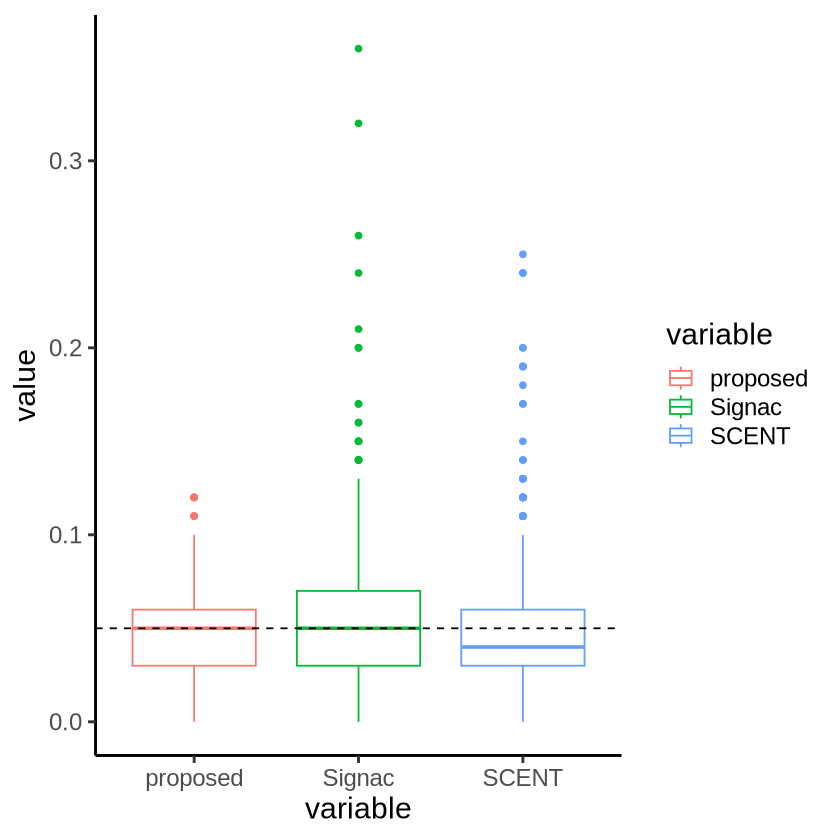

In [13]:
tmp <- null_inflation('CD14 Mono', mode, study = 'PBMC_10k_nextgem', plot_type = 'boxplot',
                     permu_peak_suffix = permu_peak_suffix)
tmp[[1]]
saveRDS(tmp[[3]], '../manuscript/results/null_type_I_error.rds')

# Brain data

In [9]:
batch_suffix_vec <- c('_batch_adjusted', '_batch_as_covar_adjusted')
names(batch_suffix_vec) <- c('proposed', 'SCENT')

permu_peak_suffix <- c('_permu_peak', '_permu_peak', '_permu_peak')
names(permu_peak_suffix) <- c('proposed', 'Signac', 'SCENT')

sampling <- 'random'
tmp <- null_inflation('Oligodendrocytes', 'permutation_batch_effect', study = 'brain_CG', 
               plot_type = 'boxplot', 
               batch_suffix = batch_suffix_vec,
              permu_peak_suffix = permu_peak_suffix,
              SCENT_bootstrap_suffix =  '')

[1] "permutation_batch_effect"
[1] "brain_CG"
[1] "Oligodendrocytes"
[1] "../../analysis/simulation//output/permutation_batch_effect/brain_CG/Oligodendrocytes_proposed_random_sampled_results_batch_adjusted_permu_peak.rds"


Using pair as id variables



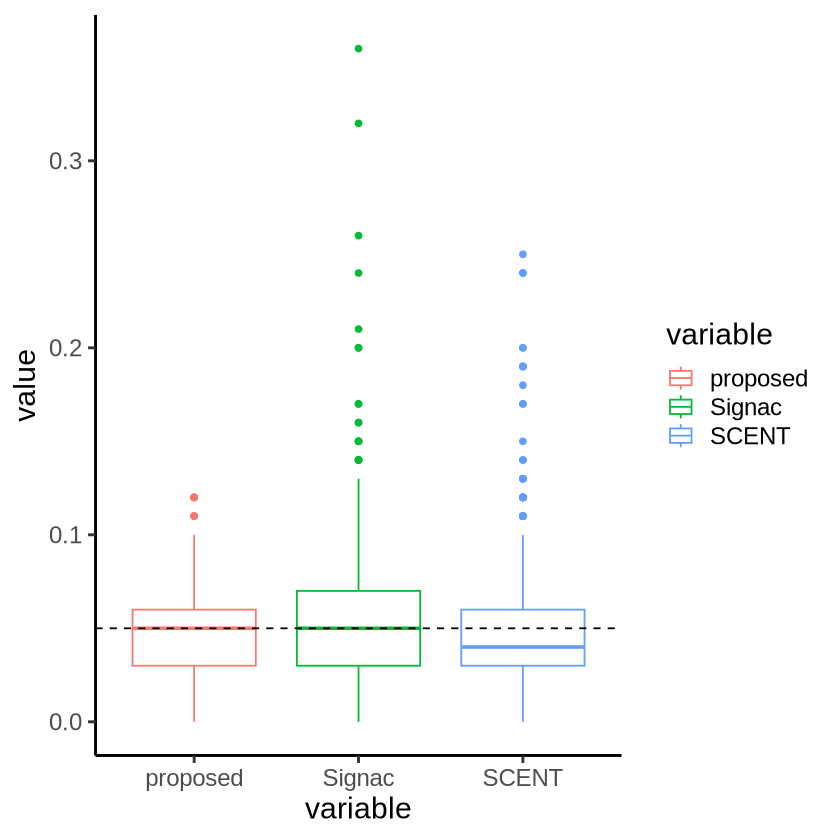

In [14]:
tmp[[1]]
saveRDS(tmp[[3]], '../manuscript/results/null_type_I_error_batch_effect.rds')